In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
import numpy as np
from box import Box
import warnings

warnings.filterwarnings('ignore')

In [92]:
with open('../src/conf/config.yaml') as f:
    cfg = Box.from_yaml(f.read())

In [4]:
cfg.target_variable

'314FT010.PNT'

#### Load Data

In [61]:
df_path = cfg.path.processed_data
df = pd.read_csv(df_path, parse_dates=['Timestamp'], index_col=0)

In [63]:
# move the target variable to the first of the dataframe
df = df[[cfg.target_variable] + [col for col in df.columns if col != cfg.target_variable]]

In [64]:
df.head()

,314FT010.PNT,314T109.PNT,314L804.PNT,314LT810.PNT,314T003.PNT,314T157.PNT,315T028.PNT,311T012.PNT,311PZ202.PNT,314P182.PNT,...,311Q750HIC4.PNT,314T967.PNT,315Q011.PNT,314FC015.MEAS,314Q030.PNT,311FC030.SPT,3141TTXD1_4.PNT,344TZ012.PNT,314Q044.PNT,344FV026.OUT
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,9872.846517,52.998047,1.549301,64.589844,20.806641,29.453007,29.582031,28.882812,1.640309,7.013008,...,0.562227,125.360107,0.401367,0.0,1.462109,21.301672,532.112081,32.310737,2.029439,-5.0
2020-01-01 01:00:00,9888.568034,52.998047,1.425070,64.867839,20.805664,28.876786,29.582031,28.667969,1.640309,7.004219,...,0.562227,125.364176,0.401367,0.0,1.469775,21.246181,528.475423,30.860799,2.029439,-5.0
2020-01-01 02:00:00,9899.958171,52.998047,1.491602,64.997070,20.873372,28.709212,29.246094,28.625000,1.419244,6.998633,...,0.562227,125.191243,0.401367,0.0,1.468262,21.306395,526.341064,29.578747,2.029439,-5.0
2020-01-01 03:00:00,9883.221354,52.998047,1.773474,64.961263,20.831055,28.491658,29.078125,28.625000,1.419244,7.002031,...,0.562227,124.890137,0.401367,0.0,1.463623,23.083295,525.785411,28.937723,2.029439,-5.0
2020-01-01 04:00:00,9892.548665,52.998047,1.776562,64.830078,20.871745,28.388762,29.078125,28.625000,1.419244,7.001719,...,0.562227,124.698893,0.401367,0.0,1.469727,26.649424,523.483480,28.365378,2.029439,-5.0


In [65]:
df.shape

(24300, 1912)

In [66]:
# select the rows in df where the target variable is larger than 100
df = df[df[cfg.target_variable] > 100]

In [67]:
df.shape

(22816, 1912)

#### XGBoost Feature Selection

In [11]:
from xgboost.sklearn import XGBRegressor

In [12]:
df.shape

(22816, 1912)

In [13]:
# check how many columns have the suffix '.MEAS'
len([col for col in df.columns if '.MEAS' in col])

141

In [15]:
new_ctrl_tags_df = pd.read_excel('../data/CV Tags Process Control.xlsx')
new_ctrl_tags_df

,Units,Tags Doc,Tags MList,Column1,Model Tags,Tags Used In Model,Priority
0,U1400,14-FICA-010,314FC010.OUT,OUT,No,No,NaN
1,U1400,14-HIC-001,314HC001,NaN,No,No,NaN
2,U1400,14-PICA-001,314PC001.MEAS,MEAS,Yes,Yes,NaN
3,U1400,14-PICA-130,314PC130.MEAS,MEAS,Yes,Yes,NaN
4,U1400,14-TRCA-016,314TC016.MEAS,MEAS,No,Yes,NaN
...,...,...,...,...,...,...,...
357,U1200,NaN,312LC008.MEAS,MEAS,NaN,Yes,NaN
358,U1200,NaN,312LC008.OUT,OUT,NaN,No,NaN
359,U1200,NaN,312LC008.SPT,SPT,NaN,No,NaN
360,U1200,NaN,312LT008.PNT,PNT,NaN,No,NaN


In [99]:
# get Tags MList from the new_ctrl_tags_df, where Column1 is 'MEAS'
new_ctrl_tags = new_ctrl_tags_df[new_ctrl_tags_df['Column1'] == 'MEAS']['Tags MList'].tolist()
print(len(new_ctrl_tags))
# delete the repeated tags
new_ctrl_tags = list(set(new_ctrl_tags))
len(new_ctrl_tags)

113


104

In [100]:
effective_new_cvs = [col for col in new_ctrl_tags if col in df.columns]
len(effective_new_cvs)

73

In [102]:
# get Tags MList from the new_ctrl_tags_df, where Column1 is 'MEAS' and Priority is 'High'
colored_tags = new_ctrl_tags_df[(new_ctrl_tags_df['Column1'] == 'MEAS') & (new_ctrl_tags_df['Priority'] == 'High')]['Tags MList'].tolist()
print(len(colored_tags))
colored_tags = list(set(colored_tags))
len(colored_tags)

28


28

In [103]:
len([tag for tag in colored_tags if tag in df.columns])

19

In [37]:
# read first 21 tags from new_selected_tags.xlsx, as old_selected_tags
old_selected_tags = pd.read_csv('../result/new_selected_tags.csv', header=None).iloc[:, 0].tolist()[:21]
len(old_selected_tags)

21

In [38]:
# check overlap between old_selected_tags and colored_tags
len([tag for tag in old_selected_tags if tag in colored_tags])

0

In [18]:
all_tags = df.columns.tolist()
all_tags.remove(cfg.target_variable)
len(all_tags)

1911

Round One

In [23]:
# build a empty integer dictionary for each cv in effective_new_cvs
feat_importance_dict = {cv: 0 for cv in all_tags}
feat_importance_dict['dummy'] = 0
len(feat_importance_dict)

1912

In [25]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

y=df[cfg.target_variable]
for i in tqdm(range(0, 20)):
    X = df.drop(cfg.target_variable,axis=1)
    np.random.seed(i)
    X['dummy'] = np.random.rand(len(X))

    xgb = XGBRegressor(random_state=123)
    xgb.fit(X, y)
    
    scaler = MinMaxScaler(feature_range=(0, 10000000))
    scaled_importances = scaler.fit_transform(xgb.feature_importances_.reshape(-1, 1)).reshape(-1)

    for feat in feat_importance_dict.keys():
        # cv_dict[cv] += scaled_importances[effective_new_cvs.index(cv)]
        feat_importance_dict[feat] += scaled_importances[X.columns.get_indexer([feat])[0]]

100%|██████████| 20/20 [1:26:09<00:00, 258.49s/it]


In [27]:
feat_importance_dict

{'314T109.PNT': 136.4858832359314,
 '314L804.PNT': 1091.4000625610352,
 '314LT810.PNT': 20106.955078125,
 '314T003.PNT': 14199.448120117188,
 '314T157.PNT': 43.050973296165466,
 '315T028.PNT': 121.02825117111206,
 '311T012.PNT': 90.02761173248291,
 '311PZ202.PNT': 69.11619544029236,
 '314P182.PNT': 163.6950511932373,
 '314T056.PNT': 198.71119689941406,
 '311LZ012.PNT': 217.5445680618286,
 '314L021.PNT': 406.50178146362305,
 '315P097.PNT': 18.550529092550278,
 '314FC751.OUT': 281.65110969543457,
 '315TZ065.PNT': 1185.7497482299805,
 '312F003.PNT': 152.936381816864,
 '341F056.PNT': 199.06722974777222,
 '314LT002.PNT': 211.161554813385,
 '314T020.PNT': 61.8872275352478,
 '341LT012.PNT': 64.71394447982311,
 '314LZ007.PNT': 125.85073232650757,
 '341FZ002.PNT': 85.55689835548401,
 '314FV009B.OUT': 8124.668853759766,
 '314LZ070.PNT': 115.75729370117188,
 '312LZ003.PNT': 111.6677018404007,
 '311T022.PNT': 98.92785573005676,
 '314F040.PNT': 3912.7585678100586,
 '311F003B.PNT': 3645.612846374511

In [28]:
# divide the sum of the feature importance by 100
for feat in feat_importance_dict.keys():
    feat_importance_dict[feat] /= 20

In [68]:
# save the cv_dict to a json file
import json
with open(cfg.path.feat_imp_dict2.round1, 'w') as f:
    json.dump(feat_importance_dict, f)

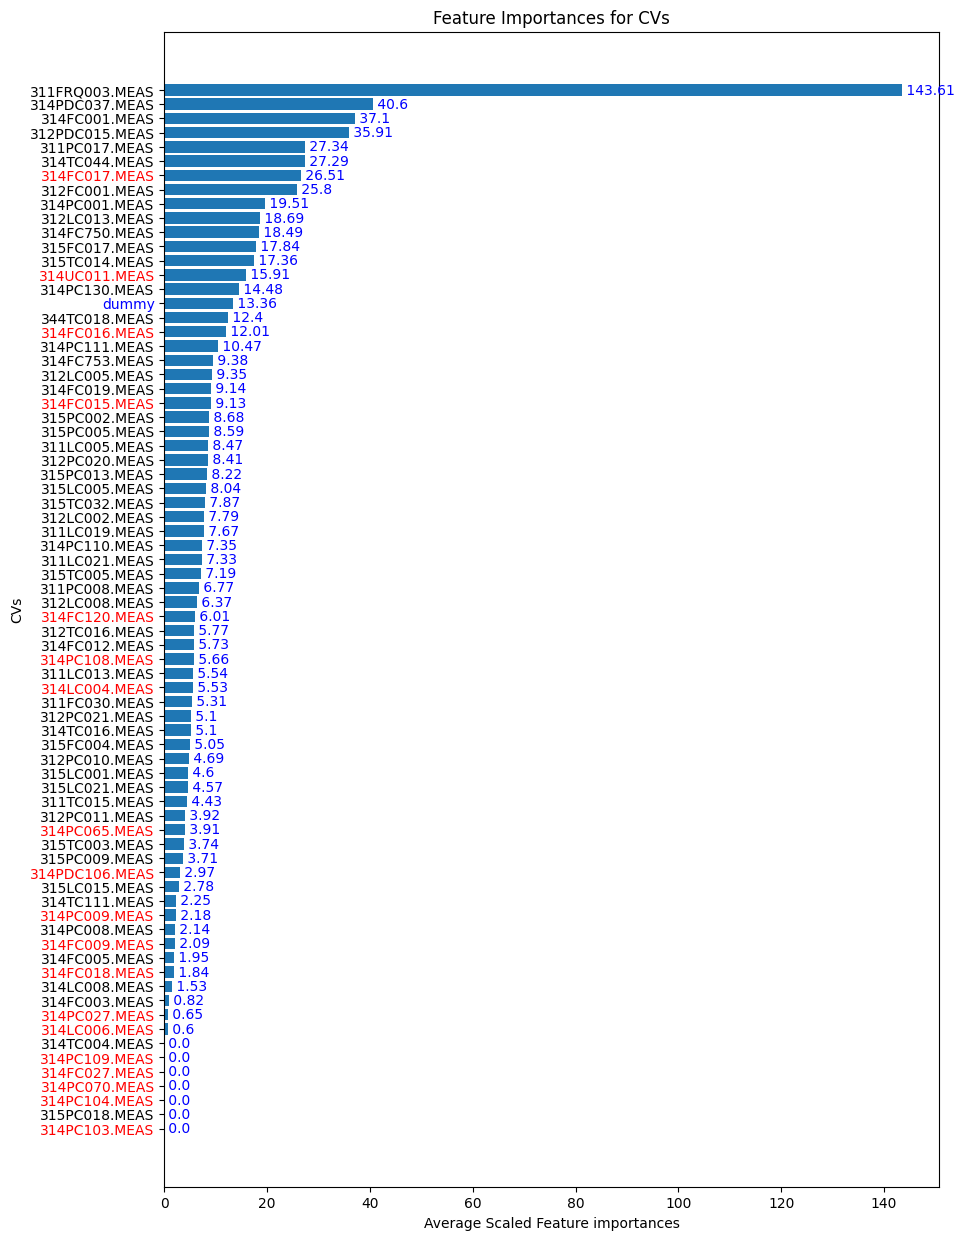

In [105]:
# extract the effective_new_cvs from feat_importance_dict
cv_dict = {cv: feat_importance_dict[cv] for cv in effective_new_cvs}
cv_dict['dummy'] = feat_importance_dict['dummy']

# plot cv_dict in the sorted order
cv_importances = np.array(list(cv_dict.values()))
plt.figure(figsize=(10, 15))
plt.barh(np.array(list(cv_dict.keys()))[np.argsort(cv_importances)], cv_importances[np.argsort(cv_importances)])

# Add title and axis names
plt.title('Feature Importances for CVs')
plt.xlabel('Average Scaled Feature importances')
plt.ylabel('CVs')


# Highlight labels
[t.set_color('blue') for t in plt.gca().get_yticklabels() if t.get_text() in ['dummy']]
[t.set_color('red') for t in plt.gca().get_yticklabels() if t.get_text() in colored_tags]
# [t.set_color('red') for t in plt.gca().get_yticklabels() if t.get_text() in original_selected_tags]

# Add y values
for i, v in enumerate(cv_importances[np.argsort(cv_importances)]):
    plt.text(v, i, " "+str(round(v, 2)), color='blue', va='center')

# save the figureq
plt.savefig('../result/latest_result/Average Scaled Feature importances.png', bbox_inches='tight')

plt.show()

In [48]:
col1 = np.array(list(cv_dict.keys()))[np.argsort(cv_importances)]
col2 = cv_importances[np.argsort(cv_importances)]
# save the result to csv, make the colored_tags in col1 red
pd.DataFrame({'CVs': col1, 'Feature Importances': col2}).to_csv('../result/latest_result/Feature Importances for CVs Round 1.csv', index=False)

In [106]:
# select the features with importance larger than 3.71 in feat_importance_dict
new_selected_cvs = [cv for cv in effective_new_cvs if feat_importance_dict[cv] > 2]
len(new_selected_cvs)

60

In [108]:
# read the old_selected_tags from new_selected_tags.xlsx
old_selected_tags = pd.read_csv('../result/new_selected_tags.csv', header=None).iloc[1:, 0].tolist()
len(old_selected_tags)

551

In [109]:
old_selected_cvs = old_selected_tags[:21]
old_selected_cvs

['311FC018.MEAS',
 '311LC013.MEAS',
 '311PC017.MEAS',
 '342LC116.MEAS',
 '312FC001.MEAS',
 '312LC002.MEAS',
 '312LC005.MEAS',
 '315PC002.MEAS',
 '315LC005.MEAS',
 '315TC014.MEAS',
 '315FC017.MEAS',
 '315TC032.MEAS',
 '315FC025.MEAS',
 '314LC810.MEAS',
 '314LC812.MEAS',
 '314PC001.MEAS',
 '314PC130.MEAS',
 '314TC037.MEAS',
 '314TC804.MEAS',
 '314FC007.MEAS',
 '314FC750.MEAS']

In [110]:
# check the overlap between new_selected_cvs and old_selected_cvs
len([cv for cv in new_selected_cvs if cv in old_selected_cvs])

13

In [111]:
selected_non_cvs = old_selected_tags[21:]
# delete the overlap between selected_non_cvs and new_selected_cvs from selected_non_cvs
selected_non_cvs = [cv for cv in selected_non_cvs if cv not in new_selected_cvs]
len(selected_non_cvs)

524

In [112]:
new_selected_feats = new_selected_cvs + selected_non_cvs
len(new_selected_feats)

584

In [113]:
# save the new_selected_feats to a csv file, remove the first row
pd.DataFrame(new_selected_feats).to_csv(cfg.path.v3.selected_tags, index=False, header=False)

#### Visualization

In [42]:
import plotly.express as px

# calculate the correlation between the target variable and cvs in effective_new_cvs, and plot the correlation using plotly bar chart
corr = df[effective_new_cvs + [cfg.target_variable]].corr()[cfg.target_variable].sort_values(ascending=False)
corr = corr.reset_index().rename(columns={'index': 'CVs', cfg.target_variable: 'Correlation'})
corr['Correlation'] = corr['Correlation'].round(2)
corr = corr[corr['CVs'] != cfg.target_variable]

fig = px.bar(corr, x='CVs', y='Correlation', color='Correlation', color_continuous_scale='RdBu')
fig.update_layout(title='Correlation between the target variable and cvs')
fig.update_layout(width=1200)
fig.update_xaxes(tickfont=dict(size=8))
# highlight the colored tags in xticks
fig.update_xaxes(tickmode='array', tickvals=corr['CVs'], ticktext=['<b>' + col + '</b>' if col in colored_tags else col for col in corr['CVs']])
fig.update_yaxes(range=[-1, 1])

# save the figure as html
fig.write_html('../result/newest_result/Correlation score for Yield tags wrt LNG product.html')

fig.show()


In [108]:
corr

,CVs,Correlation
1,314FC009.MEAS,0.99
2,314FC007.MEAS,0.84
3,314PC103.MEAS,0.82
4,314PC104.MEAS,0.82
5,314PC065.MEAS,0.77
...,...,...
82,314PC110.MEAS,-0.61
83,314FC017.MEAS,-0.68
84,311TC015.MEAS,-0.70
85,314PC006.MEAS,-0.80


In [109]:
corr.to_csv('../result/new_result/Correlation score for Yield tags wrt LNG product.csv', index=False)

#### Add Description & Save Result

In [69]:
len(new_selected_cvs)

67

In [71]:
len(new_selected_feats)

597

In [72]:
df_tags = pd.read_excel(cfg.path.tags_info, sheet_name="T3_all_tags2")
df_tags.head()

,Full Tags,Assets1,Assets,Locn,Location,Tags,Column1,Property,Description,Units,Digital (States)\n
0,311U200_GW2:311UZ200U10.CIN,311U200_GW2,311U200,3-1100,Acid Gas Removal Unit,311UZ200U10.CIN,uz,CIN,TRAIN SHUTDN 11UZ200,,N_OPENOPEN
1,311U200_GW2:311UZ200U12.CIN,311U200_GW2,311U200,3-1100,Acid Gas Removal Unit,311UZ200U12.CIN,uz,CIN,TRAIN SHUTDN 11UZ200,,N_OPENOPEN
2,311U200_GW2:311UZ200U13.CIN,311U200_GW2,311U200,3-1100,Acid Gas Removal Unit,311UZ200U13.CIN,uz,CIN,TRAIN SHUTDN 11UZ200,,N_OPENOPEN
3,311U200_GW2:311UZ200U21.CIN,311U200_GW2,311U200,3-1100,Acid Gas Removal Unit,311UZ200U21.CIN,uz,CIN,TRAIN SHUTDN 11UZ200,,N_OPENOPEN
4,311U200_GW2:311UZ200U22.CIN,311U200_GW2,311U200,3-1100,Acid Gas Removal Unit,311UZ200U22.CIN,uz,CIN,TRAIN SHUTDN 11UZ200,,N_OPENOPEN


In [73]:
df_tags.shape

(3120, 11)

In [74]:
# select the rows in df_tags where the tag is in selected_feats
selected_rows = df_tags[df_tags['Tags'].isin(new_selected_feats)]
selected_rows.head()

,Full Tags,Assets1,Assets,Locn,Location,Tags,Column1,Property,Description,Units,Digital (States)\n
19,3C1101_1:311F005A.PNT,3C1101_1,3C1101,3-1100,Acid Gas Removal Unit,311F005A.PNT,f,PNT,C1101 GAS INLET,T/D,
21,3C1101_1:311F005B.PNT,3C1101_1,3C1101,3-1100,Acid Gas Removal Unit,311F005B.PNT,f,PNT,C1101 GAS INLET,T/D,
23,3S1151_1:311F058.PNT,3S1151_1,3S1151,3-1100,Acid Gas Removal Unit,311F058.PNT,f,PNT,S1151 AMINE FILTER OUTLET,T/D,
25,3V1101_1:311F003A.PNT,3V1101_1,3V1101,3-1100,Acid Gas Removal Unit,311F003A.PNT,f,PNT,U1100 GAS IN TO V1101,T/D,
26,3V1101_1:311F003B.PNT,3V1101_1,3V1101,3-1100,Acid Gas Removal Unit,311F003B.PNT,f,PNT,U1100 GAS IN TO V1101,T/D,


In [75]:
selected_rows.shape

(584, 11)

In [76]:
# move Tags to the first of the selected_tags dataframe
selected_rows = selected_rows[['Tags'] + [col for col in selected_rows.columns if col != 'Tags']]
selected_rows.head()

,Tags,Full Tags,Assets1,Assets,Locn,Location,Column1,Property,Description,Units,Digital (States)\n
19,311F005A.PNT,3C1101_1:311F005A.PNT,3C1101_1,3C1101,3-1100,Acid Gas Removal Unit,f,PNT,C1101 GAS INLET,T/D,
21,311F005B.PNT,3C1101_1:311F005B.PNT,3C1101_1,3C1101,3-1100,Acid Gas Removal Unit,f,PNT,C1101 GAS INLET,T/D,
23,311F058.PNT,3S1151_1:311F058.PNT,3S1151_1,3S1151,3-1100,Acid Gas Removal Unit,f,PNT,S1151 AMINE FILTER OUTLET,T/D,
25,311F003A.PNT,3V1101_1:311F003A.PNT,3V1101_1,3V1101,3-1100,Acid Gas Removal Unit,f,PNT,U1100 GAS IN TO V1101,T/D,
26,311F003B.PNT,3V1101_1:311F003B.PNT,3V1101_1,3V1101,3-1100,Acid Gas Removal Unit,f,PNT,U1100 GAS IN TO V1101,T/D,


In [78]:
# move cvs rows to the top of the selected_tags dataframe, and remaining rows to the bottom
cv_rows = selected_rows[selected_rows['Tags'].isin(new_selected_cvs)]
other_rows = selected_rows[~selected_rows['Tags'].isin(new_selected_cvs)]
# combine the two dataframes
selected_tags = pd.concat([cv_rows, other_rows])
selected_tags.head()

,Tags,Full Tags,Assets1,Assets,Locn,Location,Column1,Property,Description,Units,Digital (States)\n
42,311FC030.MEAS,3V1102_2:311FC030.MEAS,3V1102_2,3V1102,3-1100,Acid Gas Removal Unit,fc,MEAS,MAKEUP WATER TO V1102,T/D,
49,311FRQ003.MEAS,3V1101_1:311FRQ003.MEAS,3V1101_1,3V1101,3-1100,Acid Gas Removal Unit,frq,MEAS,COMP U1100 GAS IN TO V1101,T/D,
110,311LC019.MEAS,3C1102_2:311LC019.MEAS,3C1102_2,3C1102,3-1100,Acid Gas Removal Unit,lc,MEAS,C1102 REGEN BOTTOMS,%,
113,311LC021.MEAS,3V1102_2:311LC021.MEAS,3V1102_2,3V1102,3-1100,Acid Gas Removal Unit,lc,MEAS,V1102 REGEN REFLUX DRUM,%,
116,311LC013.MEAS,3V1104_2:311LC013.MEAS,3V1104_2,3V1104,3-1100,Acid Gas Removal Unit,lc,MEAS,V1104 AMINE FLASH DRUM,%,


In [79]:
selected_tags.shape

(584, 11)

In [98]:
# reset the index of selected_tags
selected_tags.reset_index(drop=True, inplace=True)
selected_tags.head(22)

,Tags,Full Tags,Assets1,Assets,Locn,Location,Column1,Property,Description,Units,Digital (States)\n
0,311FC018.MEAS,3P1101_2:311FC018.MEAS,3P1101_2,3P1101,3-1100,Acid Gas Removal Unit,fc,MEAS,P1101A MIN FLOW,T/D,
1,311LC013.MEAS,3V1104_2:311LC013.MEAS,3V1104_2,3V1104,3-1100,Acid Gas Removal Unit,lc,MEAS,V1104 AMINE FLASH DRUM,%,
2,311PC017.MEAS,3V1102_2:311PC017.MEAS,3V1102_2,3V1102,3-1100,Acid Gas Removal Unit,pc,MEAS,V1102 GAS OUTLET TO ATM,BAR G,
3,342LC116.MEAS,3E4201_2:342LC116.MEAS,3E4201_2,3E4201,3-4200,Cooling Water System,lc,MEAS,A4201 CW BASIN,%,
4,312FC001.MEAS,3F1211_2:312FC001.MEAS,3F1211_2,3F1211,3-1200,Dehydration Unit,fc,MEAS,F1211 REGEN CIRCUIT FLOW,T/D,
5,312LC002.MEAS,3V1203_2:312LC002.MEAS,3V1203_2,3V1203,3-1200,Dehydration Unit,lc,MEAS,V1203 FEED GAS SEP,%,
6,312LC005.MEAS,3V1202_2:312LC005.MEAS,3V1202_2,3V1202,3-1200,Dehydration Unit,lc,MEAS,V1202 INTERFACE LEVEL,%,
7,315PC002.MEAS,3C1540_4:315PC002.MEAS,3C1540_4,3C1540,3-1500,Fractionation Unit,pc,MEAS,DEMETHANIZER C1540 OVHD,BAR G,
8,315LC005.MEAS,3C1550_4:315LC005.MEAS,3C1550_4,3C1550,3-1500,Fractionation Unit,lc,MEAS,DEETHANIZER C1550 BTM,%,
9,315TC014.MEAS,3C1550_4:315TC014.MEAS,3C1550_4,3C1550,3-1500,Fractionation Unit,tc,MEAS,DEETHANIZER C1550 OVHD,DEG C,


In [100]:
selected_tags.to_csv(cfg.path.new_selected_tags, index=False)

#### Get Min & Max of the CVs

In [114]:
# create a new dataframe with MEAS_tags as rows, two columns: Min, Max
cv_df = pd.DataFrame(new_selected_cvs, columns=['Tags'])
cv_df['Min'] = np.nan
cv_df['Max'] = np.nan
cv_df

,Tags,Min,Max
0,314PDC037.MEAS,NaN,NaN
1,314FC019.MEAS,NaN,NaN
2,312TC016.MEAS,NaN,NaN
3,315TC032.MEAS,NaN,NaN
4,344TC018.MEAS,NaN,NaN
5,315PC005.MEAS,NaN,NaN
6,312LC013.MEAS,NaN,NaN
7,315FC004.MEAS,NaN,NaN
8,314FC012.MEAS,NaN,NaN
9,314LC004.MEAS,NaN,NaN


In [115]:
# for each tag in cv_df, Min is the minimum value of the tag in df, Max is the maximum value of the tag in df
for tag in cv_df['Tags']:
    cv_df.loc[cv_df['Tags'] == tag, 'Min'] = df[tag].quantile(0.05)
    cv_df.loc[cv_df['Tags'] == tag, 'Max'] = df[tag].quantile(0.95)
cv_df

,Tags,Min,Max
0,314PDC037.MEAS,-0.044141,33.020510
1,314FC019.MEAS,0.000000,152.793713
2,312TC016.MEAS,110.700521,320.380208
3,315TC032.MEAS,26.274256,103.579322
4,344TC018.MEAS,24.356934,38.918457
5,315PC005.MEAS,0.661377,20.113688
6,312LC013.MEAS,6.148674,29.627816
7,315FC004.MEAS,0.135039,661.443169
8,314FC012.MEAS,0.000000,0.013259
9,314LC004.MEAS,57.014974,63.204427


In [116]:
# plot all MEAS_tags one by one
# for tag in cv_df['Tags']:
#     plt.figure(figsize=(20, 5))
#     plt.plot(df[tag])
#     plt.title(tag)
#     plt.show()
    

In [117]:
# save cv_df to csv
cv_df.to_csv('../result/latest_result/new_cvs_min_max.csv', index=False)

In [118]:
# There are some gaps, because we dropped some rows in df
df.loc['2022-08-31':].head()

,314FT010.PNT,314T109.PNT,314L804.PNT,314LT810.PNT,314T003.PNT,314T157.PNT,315T028.PNT,311T012.PNT,311PZ202.PNT,314P182.PNT,...,311Q750HIC4.PNT,314T967.PNT,315Q011.PNT,314FC015.MEAS,314Q030.PNT,311FC030.SPT,3141TTXD1_4.PNT,344TZ012.PNT,314Q044.PNT,344FV026.OUT
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-09-02 18:00:00,297.512530,27.233398,1.765075,56.371419,29.862956,27.938956,27.876302,83.552409,1.801107,6.810781,...,1.404620,58.504232,0.004102,0.000000,0.081689,0.0,430.944082,28.548528,85.841801,-5.0
2022-09-07 20:00:00,340.219244,27.089844,1.751783,56.474284,26.823893,27.015826,26.916016,66.878255,1.997400,6.820351,...,0.773854,119.704183,0.003711,23.849540,0.340869,0.0,472.223282,26.785707,8.151817,-5.0
2022-09-07 21:00:00,2399.741333,26.951172,1.740910,56.320312,26.432292,26.586600,26.848307,59.451823,1.933509,6.813398,...,0.773854,120.109049,0.003711,12.526955,0.410791,0.0,525.647227,26.785707,2.104640,-5.0
2022-09-07 22:00:00,3052.404053,26.821615,1.727287,56.382487,25.819336,26.389626,26.669271,51.637695,1.933509,6.807226,...,0.773854,120.760091,0.003711,1.951207,0.476465,0.0,545.659159,26.785707,1.512932,-5.0
2022-09-07 23:00:00,3039.248454,26.671875,1.718225,56.415039,26.313477,26.307309,26.507161,51.749349,1.933509,6.809609,...,0.773854,121.087646,0.003711,0.000000,0.569434,0.0,529.522034,26.785707,1.959828,-5.0
